In [1]:
from helpers.shared_imports import *
%matplotlib inline

In [47]:
from helpers.nn_training import run_models, create_and_train_network
from helpers.util import get_possible_configurations, read_config
from helpers.evaluation import get_parameter_count, get_min_error, get_model_metrics, get_keras_model
from helpers.preprocessing import get_train_val_datasets

In [16]:
import pandas as pd

**Specify hyperparameters**


Other hyperparameters can be incorporated but you may need to modify the code slightly in `helpers/util`

Here we set all hyperparameters to a single value except a few different network architectures; `hid_layer_dims`

In [3]:
hyper_param_grid = {}
hyper_param_grid['learning_rate'] = [1e-3]
hyper_param_grid['hid_layer_dims'] = [[100]*1, [100]*2, [100]*3]
hyper_param_grid['output_indices'] = [[6,7]]
hyper_param_grid['batch_size'] = [512]
hyper_param_grid['learning_rule'] = ['adam']

configurations = get_possible_configurations(hyper_param_grid)
configurations

[OrderedDict([('output_indices', [6, 7]),
              ('learning_rule', 'adam'),
              ('learning_rate', 0.001),
              ('batch_size', 512),
              ('hid_layer_dims', [100])]),
 OrderedDict([('output_indices', [6, 7]),
              ('learning_rule', 'adam'),
              ('learning_rate', 0.001),
              ('batch_size', 512),
              ('hid_layer_dims', [100, 100])]),
 OrderedDict([('output_indices', [6, 7]),
              ('learning_rule', 'adam'),
              ('learning_rate', 0.001),
              ('batch_size', 512),
              ('hid_layer_dims', [100, 100, 100])])]

In [4]:
data_path = 'datasets/bebop_power.npy'

**Train a single network inline and not export anything**

Neural network training details are not listed here (see paper or *helpers* code).

We should note that the *patience* values for early stopping and learning rate decay were selected based on a training set corresponding to 160,000 trajectories.

The dataset included in this repo is simply for demonstration purposes only (satisfies GitHub file size limit)

In [12]:
config = configurations[0]
create_and_train_network(config, data_path, epochs=5)

Train on 1227200 samples, validate on 153400 samples
Epoch 1/5
1227200/1227200 [==============================] - 8s 6us/step - loss: 0.0218 - mean_absolute_error: 0.0855 - val_loss: 0.0189 - val_mean_absolute_error: 0.0803
Epoch 2/5
1227200/1227200 [==============================] - 7s 6us/step - loss: 0.0180 - mean_absolute_error: 0.0791 - val_loss: 0.0187 - val_mean_absolute_error: 0.0799
Epoch 3/5
1227200/1227200 [==============================] - 7s 6us/step - loss: 0.0173 - mean_absolute_error: 0.0765 - val_loss: 0.0173 - val_mean_absolute_error: 0.0753
Epoch 4/5
1227200/1227200 [==============================] - 8s 6us/step - loss: 0.0156 - mean_absolute_error: 0.0705 - val_loss: 0.0157 - val_mean_absolute_error: 0.0682
Epoch 5/5
1227200/1227200 [==============================] - 8s 6us/step - loss: 0.0136 - mean_absolute_error: 0.0630 - val_loss: 0.0128 - val_mean_absolute_error: 0.0585


**Train multiple models in parallel and export metrics and model**

Uses *multiprocessing* for parallelisation.

Note that the following code may take a long while to run as all models train for a minimum of 100 epochs before early stopping kicks in.

I would recommend to change the default value of argument `epochs` to say 5 in function `create_and_train_network()` within `helpers/nn_training`.
And reimport the module.

For each model, we export the files:
* *best_model.h5* - keras model
* *config.txt* - dictionary of model properties (see above)
* *log.out* - keras training feed redirected from stdout
* *metrics_loss.npz* - MSE metrics on train/val set for each epoch (and minibatch for train)
* metrics_mean_absolute_error.npz* - MAE metrics

In [5]:
models_path = 'models/bebop_power2' # where to store trained models

run_models(configurations, models_path, data_path, n_processes=3)

model-4099158344583306909
model-5588947709159987985
model4331790190273754659


There is also code for training multiple models over a number of GPUs from a single process.

This is in `helpers/nn_training_gpu`.

In [34]:
# run_models_gpu(configurations, models_path, data_path, gpus_available=[2,3,4,6,7,8,9])

**Pickling important parameters**

From each model, we extract its network configuration and the weights and biases. 
Along with the input and output scalers, these variables are all serialised.

We do this to avoid (from this notebook onwards) dealing with objects created by ML libraries.
The pickled file is used as a constructor argument for a *Controller* class in `helpers/integrate` so we can use the network outputs as a control feedback in simulation.

In [49]:
export_dir = 'models_pickled/bebop_power'
models_path = 'models/bebop_power'

for config in configurations:
    model = get_keras_model(config, models_path)
    _, scalers = get_train_val_datasets(data_path)

    n_layers = len(config['hid_layer_dims'])
    n_units = config['hid_layer_dims'][0]
    filename = 'power_bebop_h{0:02}_n{1:04}.pkl'.format(n_layers, n_units)
    export_path = os.path.join(export_dir, filename)

    pickle_controller_params(model, scalers, export_path)

**Compare trained models by final error**

In [15]:
# get all model configs stored in path
models_path = 'models/bebop_power'

mdl_id_lst = os.listdir(models_path)
configurations = [0 for _ in range(len(mdl_id_lst))]

for i, mdl_id in enumerate(mdl_id_lst):
    path_to_config = os.path.join(models_path, mdl_id, 'config.txt')
    configurations[i] = read_config(path_to_config)

In [21]:
def construct_model_summary(config):    
    mdl_attr = {}
    hid_layer_dims = config['hid_layer_dims']
    mdl_attr['units/layer'] = hid_layer_dims[0]
    mdl_attr['n_hidden_layers'] = len(hid_layer_dims)
    mdl_attr['parameter count'] = get_parameter_count(config['hid_layer_dims'])
    mdl_attr['MAE'] = get_min_error(config, models_path)  # default metric is MAE on validation set
    
    return mdl_attr

mdl_attr_lst = [construct_model_summary(config) for config in configurations]

lbls = ['units/layer', 'n_hidden_layers', 'parameter count', 'MAE']
df = pd.DataFrame(mdl_attr_lst)[lbls]
# df.to_csv('summary.csv', sep='\t', encoding='utf-8', index=False) # load in excel to analyse training results
df

,units/layer,n_hidden_layers,parameter count,MAE
0,200,4,122202,0.005916
1,100,4,31102,0.006137
2,50,4,8052,0.007504
3,50,10,23352,0.009253
4,100,9,81602,0.005971
5,50,2,2952,0.011257
6,50,3,5502,0.007948
7,50,5,10602,0.007929
8,200,2,41802,0.007335
9,100,7,61402,0.005907


**Plot learning curve**

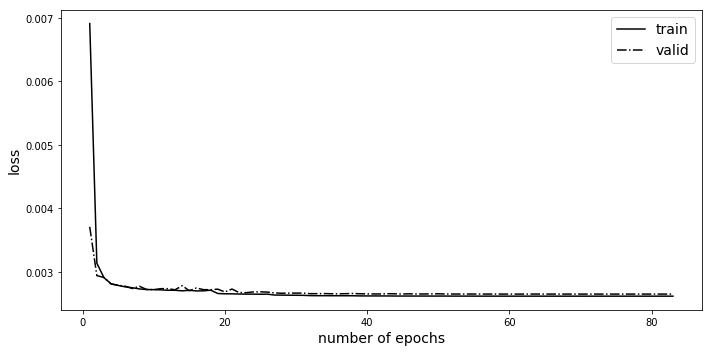

In [33]:
metric_lbl = 'loss' # 'loss', 'mean_absolute_error'

fig, ax = plt.subplots(figsize=(10,5))

config = configurations[0]
metrics = get_model_metrics(config, models_path)

train_metrics = metrics['train_' + metric_lbl]
valid_metrics = metrics['val_' + metric_lbl]

ax.plot(np.arange(len(train_metrics))+1, train_metrics, 'k', label='train')
ax.plot(np.arange(len(valid_metrics))+1, valid_metrics, 'k-.', label='valid')

ax.set_xlabel('number of epochs', fontsize=14)
ax.set_ylabel('loss', fontsize=14)
leg = ax.legend(loc='upper right', fontsize=14)

fig.tight_layout()